In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import torch

# Define a function that creates a Toeplitz matrix from a parameter vector.
def toeplitz_from_params(params, n_rows, n_cols):
    """
    Constructs a Toeplitz matrix of shape (n_rows, n_cols) where:
      - params is a 1D tensor of length n_rows + n_cols - 1.
      - The main diagonal is at index n_rows - 1 in params.
      - For i, j, the element at (i, j) is params[j - i + (n_rows - 1)].
    """
    # Create index grids for rows and columns.
    i = torch.arange(n_rows).unsqueeze(1).expand(n_rows, n_cols)
    j = torch.arange(n_cols).unsqueeze(0).expand(n_rows, n_cols)
    # Calculate indices into the params vector.
    indices = j - i + (n_rows - 1)
    # Gather values from the params tensor.
    return params[indices]

# Example dimensions.
n_rows, n_cols = 4, 4
# Create a learnable parameter vector of the appropriate length.
# The length should be n_rows + n_cols - 1.
# toeplitz_params = torch.nn.Parameter(torch.randn(n_rows + n_cols - 1))
toeplitz_params = torch.nn.Parameter(torch.arange(n_rows + n_cols - 1).float())
# Construct the Toeplitz matrix.
T = toeplitz_from_params(toeplitz_params, n_rows, n_cols)
print("Toeplitz matrix:\n", T)

# Demonstrate differentiability: define a dummy loss and backpropagate.
loss = T.sum()
loss.backward()
print("\nGradient with respect to toeplitz_params:\n", toeplitz_params.grad)

Toeplitz matrix:
 tensor([[3., 4., 5., 6.],
        [2., 3., 4., 5.],
        [1., 2., 3., 4.],
        [0., 1., 2., 3.]], grad_fn=<IndexBackward0>)

Gradient with respect to toeplitz_params:
 tensor([1., 2., 3., 4., 3., 2., 1.])


In [7]:

# Example dimensions.
n_rows, n_cols = 5, 5
# Create a learnable parameter vector of the appropriate length.
# The length should be n_rows + n_cols - 1.
# toeplitz_params = torch.nn.Parameter(torch.randn(n_rows + n_cols - 1))
toeplitz_params = torch.nn.Parameter(torch.arange(n_rows + n_cols - 1).float())
# Construct the Toeplitz matrix.
T = toeplitz_from_params(toeplitz_params, n_rows, n_cols)
T

tensor([[4., 5., 6., 7., 8.],
        [3., 4., 5., 6., 7.],
        [2., 3., 4., 5., 6.],
        [1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4.]], grad_fn=<IndexBackward0>)

In [8]:
# construct a symmetric matrix 
Sigma = torch.randn(n_rows, n_cols)
Sigma = Sigma @ Sigma.T
Sigma

tensor([[11.1307,  2.9246,  2.8395,  0.3486,  4.1266],
        [ 2.9246,  5.0405,  5.9646,  2.3014, -0.6465],
        [ 2.8395,  5.9646, 12.9040,  4.8026, -2.3738],
        [ 0.3486,  2.3014,  4.8026,  4.9132, -2.0603],
        [ 4.1266, -0.6465, -2.3738, -2.0603,  3.6429]])

In [9]:
T @ Sigma

tensor([[111.6349,  83.6266, 133.2329,  59.6269,  13.7525],
        [ 90.2650,  68.0420, 109.0960,  49.3214,  11.0636],
        [ 68.8952,  52.4574,  84.9591,  39.0160,   8.3746],
        [ 47.5254,  36.8727,  60.8222,  28.7105,   5.6857],
        [ 26.1555,  21.2881,  36.6853,  18.4050,   2.9967]],
       grad_fn=<MmBackward0>)

In [15]:
# toeplitz_params = torch.nn.Parameter(torch.arange(n_rows + n_cols - 1).float())
toeplitz_params = torch.zeros(n_rows + n_cols - 1)
toeplitz_params[n_rows] = 1.0
# Construct the Toeplitz matrix.
T = toeplitz_from_params(toeplitz_params, n_rows, n_cols)
Sigma = torch.randn(n_rows, n_cols)
Sigma = Sigma @ Sigma.T
Sigma.requires_grad = True
T @ Sigma

tensor([[-2.0053,  3.7825,  0.1258, -0.1789, -2.8215],
        [-3.9712,  0.1258,  7.3355,  2.8870, -0.2278],
        [-1.4935, -0.1789,  2.8870,  1.3392, -1.0028],
        [ 1.1629, -2.8215, -0.2278, -1.0028,  8.6913],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<MmBackward0>)

In [18]:
# Function to construct a vector from the sum of traces of diagonals
def vector_from_matrix_diagonals(matrix):
    n_rows, n_cols = matrix.shape
    assert n_rows == n_cols, "Matrix must be square"
    n = n_rows
    
    # Initialize the vector to store diagonal sums
    vector = torch.zeros(2*n-1)
    
    # Main diagonal (k=0)
    vector[n-1] = torch.trace(matrix)
    
    # Upper diagonals (k>0)
    for k in range(1, n):
        # Extract the k-th diagonal
        diag_values = torch.diagonal(matrix, offset=k)
        vector[n-1+k] = diag_values.sum()
    
    # Lower diagonals (k<0)
    for k in range(1, n):
        # Extract the -k-th diagonal
        diag_values = torch.diagonal(matrix, offset=-k)
        vector[n-1-k] = diag_values.sum()
    
    return vector


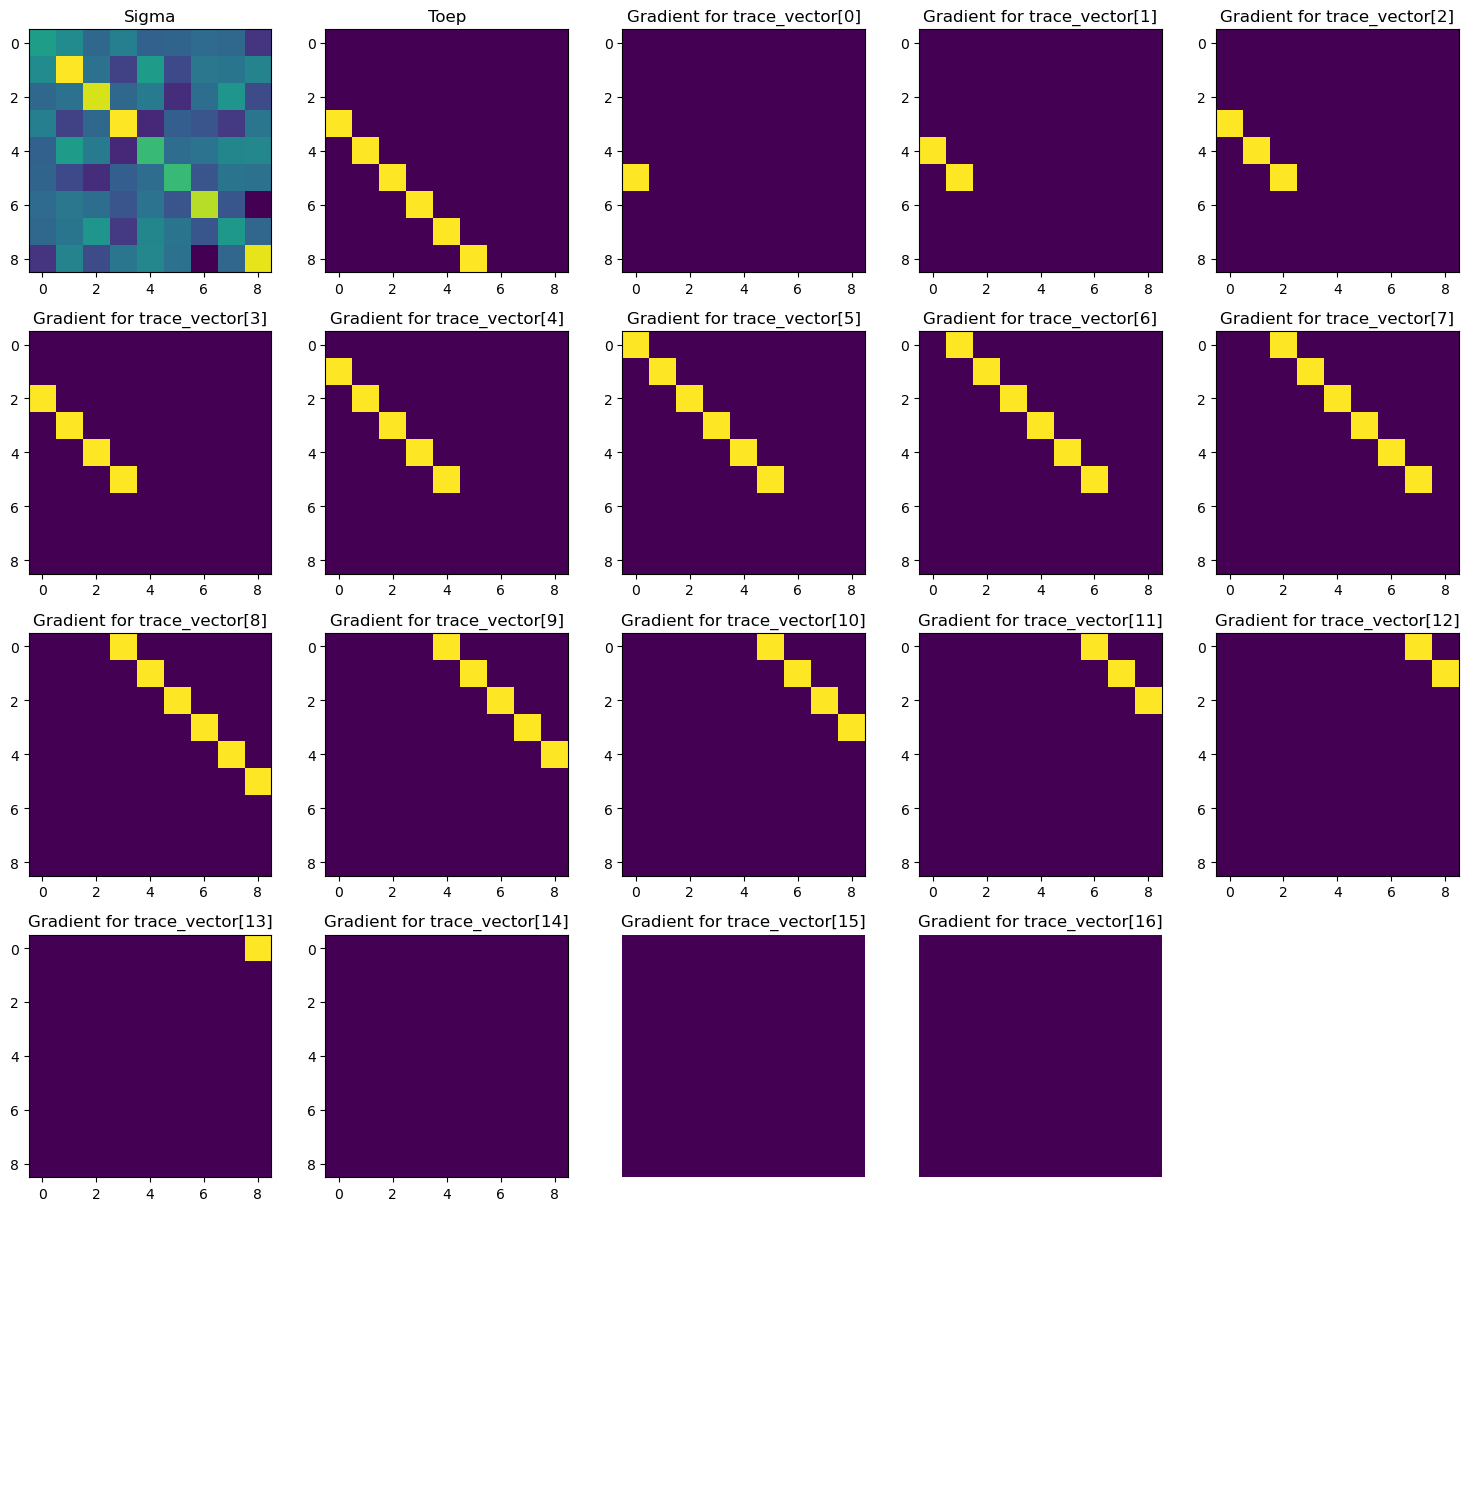

In [63]:
import matplotlib.pyplot as plt
# toeplitz_params = torch.nn.Parameter(torch.arange(n_rows + n_cols - 1).float())
n_rows = 9
n_cols = 9
toeplitz_params = torch.zeros(n_rows + n_cols - 1)
toeplitz_params[n_rows - 4] = 1.0
# Construct the Toeplitz matrix.
Toep = toeplitz_from_params(toeplitz_params, n_rows, n_cols)
Sigma = torch.randn(n_rows, n_cols)
Sigma = Sigma @ Sigma.T
Sigma.requires_grad = True
trace_vector = vector_from_matrix_diagonals(Toep @ Sigma)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.ravel()
axs[0].imshow(Sigma.detach().numpy(), cmap='viridis')
axs[0].set_title('Sigma')
axs[1].imshow(Toep.detach().numpy(), cmap='viridis')
axs[1].set_title('Toep')
for i in range(n_rows + n_cols - 1):
    grad = torch.autograd.grad(trace_vector[i], Sigma, retain_graph=True)[0]
    # Plot the gradient matrix
    axs[i+2].imshow(grad.detach().numpy(), cmap='viridis')
    # plt.colorbar()
    axs[i+2].set_title(f'Gradient for trace_vector[{i}]')
    # # Print the gradient for reference
    # print(f"Gradient for trace_vector[{i}]:")
    # print(grad)

for i in range(n_rows + n_cols - 1, len(axs)):
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
vector_from_matrix_diagonals(Sigma)

In [16]:
T

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

$$
P=\begin{bmatrix}0 & 1 & 0 & \cdots & 0\\
0 & 0 & 1 & \cdots & 0\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & \cdots & 1\\
0 & 0 & 0 & \cdots & 0
\end{bmatrix}.
$$

$$S(k)=\begin{cases}
P^{k}, & k\ge0,\\
(P^{T})^{-k}, & k<0,
\end{cases}$$

$$\mathcal{T}[k,m]={Tr}[S(m)(\sigma^{2}I+\Sigma)S(k)^{T}]$$

In [115]:
import torch

def shift_operator_noncyclic(k, n, device=None):
    """
    Returns the non-cyclic shift operator S(k) as an n x n matrix.
    For k >= 0, S(k) shifts a vector downward by k positions (zeros at the top).
    For k < 0, S(k) shifts a vector upward by -k positions (zeros at the bottom).
    """
    if device is None:
        device = torch.device('cpu')
    
    S = torch.zeros(n, n, device=device)
    
    if k >= 0:
        # For k >= 0, S(k)[i, j] = 1 if i = j + k, for j such that j + k < n.
        # Equivalently, we fill the block S[k:n, 0:n-k] with an identity.
        S[k:n, 0:n-k] = torch.eye(n - k, device=device)
    else:
        # For k < 0, let p = -k. Then S(k)[i, j] = 1 if i = j - k (i.e. j = i + p)
        # for i such that i + p < n.
        p = -k
        S[0:n-p, p:n] = torch.eye(n - p, device=device)
    
    return S


def T_function_noncyclic(k, m, sigma2, Sigma):
    """
    Computes the function T[k, m] = Tr[S(k)S(m)(sigma^2 I + Sigma)]
    using the non-cyclic (zero–padded) shift operator.
    
    Parameters:
        k (int): first shift index.
        m (int): second shift index.
        sigma2 (float or torch scalar): the variance term.
        Sigma (torch.Tensor): an n x n matrix.
        
    Returns:
        torch.Tensor: a scalar tensor equal to the trace.
    """
    n = Sigma.shape[0]
    device = Sigma.device
    I = torch.eye(n, device=device)
    M = sigma2 * I + Sigma
    
    # Get the non-cyclic shift operators
    S_k = shift_operator_noncyclic(k, n, device=device)
    S_m = shift_operator_noncyclic(m, n, device=device)
    
    # Multiply the two shift matrices and then by M
    product = S_m @ M @ S_k.T
    
    # Return the trace of the product
    return torch.trace(product)

# Example usage:
if __name__ == "__main__":
    n = 11  # matrix dimension
    sigma2 = 0.5
    device = torch.device('cpu')
    # Create an example Sigma (symmetric for demonstration)
    A = torch.randn(n, n, device=device)
    Sigma = (A + A.T) / 2

    k = 2   # shift down by 2
    m = -1  # shift up by 1
    T_val = T_function_noncyclic(k, m, sigma2, Sigma)
    print("T[{}, {}] = {}".format(k, m, T_val.item()))
    # build the T matrix k from -2 to 2
    T_matrix = torch.zeros(5, 5)
    for k in range(-2, 3):
        for m in range(-2, 3):
            T_matrix[k+2, m+2] = T_function_noncyclic(k, m, sigma2, Sigma)
    
T_matrix
    
    

T[2, -1] = -3.7279253005981445


tensor([[ 2.9153, -1.1888, -4.4044, -3.7279, -1.2051],
        [-1.1888,  3.8364, -0.8797, -4.4044, -3.7279],
        [-4.4044, -0.8797,  4.0973, -0.8797, -4.4044],
        [-3.7279, -4.4044, -0.8797,  3.7231, -1.4712],
        [-1.2051, -3.7279, -4.4044, -1.4712,  2.3368]])

In [116]:
def build_T_matrix(Sigma, sigma2, index_range=(-3,3)):
    n = Sigma.shape[0]
    k_neg, k_pos = index_range
    index_range = (k_neg, k_pos+1)
    T_matrix_size = k_pos - k_neg + 1
    T_matrix = torch.zeros(T_matrix_size, T_matrix_size)
    for k in range(k_neg, k_pos+1):
        for m in range(k_neg, k_pos+1):
            T_matrix[k-k_neg, m-k_neg] = T_function_noncyclic(k, m, sigma2, Sigma)
    return T_matrix


n = 15  # matrix dimension
sigma2 = 0.0
device = torch.device('cpu')
# Create an example Sigma (symmetric for demonstration)
A = torch.randn(n, 100, device=device)
Sigma = (A @ A.T) / 2
T_matrix = build_T_matrix(Sigma, sigma2, index_range=(-5, 5))
T_matrix

tensor([[ 4.9552e+02,  7.6487e+00,  4.5898e+00, -5.3549e+00,  1.9301e+01,
         -9.9047e+00, -1.8652e+01, -6.7970e+00,  1.0262e+01, -1.3319e+01,
         -2.1439e+01],
        [ 7.6487e+00,  5.5469e+02,  3.4669e+00,  4.2592e+00, -2.2363e+01,
          2.6534e+01, -9.9047e+00, -1.8652e+01, -6.7970e+00,  1.0262e+01,
         -1.3319e+01],
        [ 4.5898e+00,  3.4669e+00,  6.0819e+02,  3.9229e+00, -4.8412e+00,
         -2.5260e+01,  2.6534e+01, -9.9047e+00, -1.8652e+01, -6.7970e+00,
          1.0262e+01],
        [-5.3549e+00,  4.2592e+00,  3.9229e+00,  6.6159e+02, -9.8097e-01,
         -7.1292e+00, -2.5260e+01,  2.6534e+01, -9.9047e+00, -1.8652e+01,
         -6.7970e+00],
        [ 1.9301e+01, -2.2363e+01, -4.8412e+00, -9.8097e-01,  7.0582e+02,
         -6.6403e+00, -7.1292e+00, -2.5260e+01,  2.6534e+01, -9.9047e+00,
         -1.8652e+01],
        [-9.9047e+00,  2.6534e+01, -2.5260e+01, -7.1292e+00, -6.6403e+00,
          7.5191e+02, -6.6403e+00, -7.1292e+00, -2.5260e+01,  2.6534e+0

In [120]:
T_matrix = build_T_matrix(torch.zeros(n, n), 1, index_range=(-3, 3))
T_matrix

tensor([[12.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 13.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 14.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 13.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 12.]])

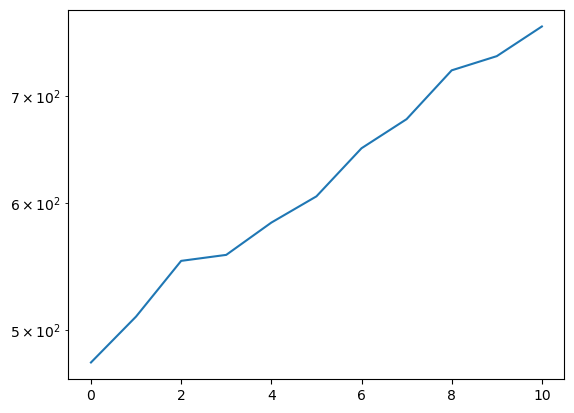

In [117]:
# compute eigenvectors and eigenvalues of T_matrix
eigval, eigvec = torch.linalg.eigh(T_matrix)
plt.plot(eigval.detach().numpy()) 
plt.yscale('log')  

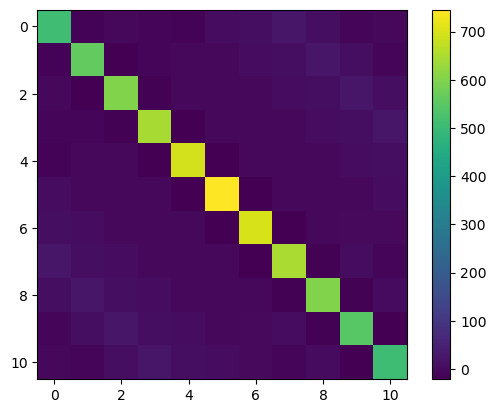

In [ ]:
plt.imshow(T_matrix.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [82]:
T_matrix

tensor([[-0.2462, -0.7864,  0.4945,  3.9405,  4.2868],
        [-0.7864,  0.4945,  4.3930,  4.8486,  3.9405],
        [ 0.4945,  4.3930,  7.3398,  4.3930,  0.4945],
        [ 3.3129,  7.3192,  4.3930,  0.4945, -0.7864],
        [ 6.8608,  3.3129,  0.4945, -0.7864, -0.2462]])

In [80]:
shift_operator_noncyclic(-6, 5)

RuntimeError: Trying to create tensor with negative dimension -1: [-1]

In [88]:
k, m, n = 2, -2, 6
S_k = shift_operator_noncyclic(k, n, device=device)
S_m = shift_operator_noncyclic(m, n, device=device)
S_k @ S_m

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])